In [1]:
'''
NON linear BVP:
     - div( mu(u) * grad(u) ) = f  in domain
                                          u = g  on bdry dirichlet
                         - mu(u) nabla(u).n = c (u^q -u_ref^q) on the 'radiative' bdry
                         - mu(u) nabla(u).n = 0 elsewhere

The diffusivity mu(u) is given, linear or not. 
The RHS (f, u_f) are given.
'''

from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import fenics as fe
from mshr import *
from mshr import Polygon, generate_mesh
from sys import exit
import numpy.linalg as npl
import warnings
warnings.filterwarnings("ignore")
from math import *
set_log_active(False)

## Problem setup

In [88]:
# parameters
tol_bc = 1e-12 # tolerance to be on the domain boundary
eps_du = 1e-9  # tolerance for the non-linear algorithms
I_max = 1000 # max number of iterations of the non-linear algorithms
q_degree = 2 # FE degree
dx = dx(metadata={'quadrature_degree': q_degree})

### a) Setup 2D geometry and scenario

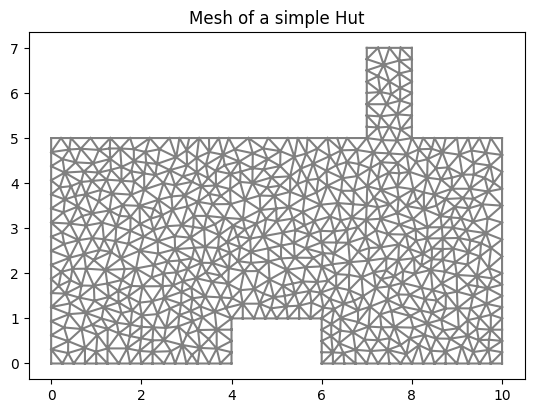

In [3]:
# Create empty Mesh 
mesh = Mesh()

# Create list of polygonal domain vertices
domain_vertices = [
    Point(0.0, 0.0), # edge of house
    Point(4.0, 0.0), # edge fireplace
    Point(4.0, 1.0), # edge fireplace
    Point(6.0, 1.0), # edge fireplace
    Point(6.0, 0.0), # edge fireplace
    Point(10.0, 0.0), # edge of house
    Point(10.0, 1.0), # edge window
    Point(10.0, 2.0), # edge window
    Point(10.0, 5.0), # edge of house
    Point(8.0, 5.0), # edge chimney
    Point(8.0, 7.0), # edge chimney
    Point(7.0, 7.0), # edge chimney
    Point(7.0, 5.0), # edge chimney
    Point(0.0, 5.0), # edge of house
]

domain = Polygon(domain_vertices)
mesh = generate_mesh(domain, 20)
plot(mesh)
plt.title("Mesh of a simple Hut")
plt.show()
V = FunctionSpace(mesh, 'P', 1)

### Detail boundary conditions

In [4]:
# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())  # CellFunction
domains.set_all(0)

# Define new measures associated with the interior domains
dx = Measure("dx", domain=mesh, subdomain_data=domains)

# Define the boundaries
wall_thick = 0.5 # 0.5
roof_thick = 0.8 # 0.8
chimney_thick = 0.2 # 0.2
floor_thick = 0.5 # 0.5
window_thick = 0.06 # 0.06
fireplace_thick = 0.1 # 0.10

class Wall(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            near(x[0], 0)
            or (near(x[0], 10) and x[1] <= 1)
            or (near(x[0], 10) and x[1] >= 2)
        )

class Roof(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            (near(x[1], 5) and x[0] <= 7) or (near(x[1], 5) and x[0] >= 8)
        )

class Chimney(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            (near(x[0], 7) and x[1] >= 5)
            or (near(x[0], 8) and x[1] >= 5)
            or (near(x[1], 7))
        )

class Floor(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0) and (x[0] <= 4 or x[0] >= 6)

class Window(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 10) and between(x[1], (1, 3.5)))

class Fire(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 1) and between(x[0], (4, 6)))

class Brick(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 4) and x[1] <= 1) or (near(x[0], 6) and x[1] <= 1)

class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return between(x[1], (0.5, 0.7)) and between(x[0], (0.2, 1.0))


# create a cell function over the boundaries edges
sub_boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) # mesh.topology().dim()-1
# set marker to 6
sub_boundaries.set_all(0)

wall = Wall()
wall.mark(sub_boundaries, 1)

roof = Roof()
roof.mark(sub_boundaries, 2)

chimney = Chimney()
chimney.mark(sub_boundaries, 3)

floor = Floor()
floor.mark(sub_boundaries, 4)

window = Window()
window.mark(sub_boundaries, 5)

fire = Fire()
fire.mark(sub_boundaries, 6)

brick = Brick()
brick.mark(sub_boundaries, 7)

# redefining integrals over boundaries
ds = Measure('ds', domain=mesh, subdomain_data=sub_boundaries)
#ds(1) = Gamma_wall ds(2) = Gamma_roof ; ds(3) = Gamma_chimney ; ds(4) = Gamma_floor ; ds(5) = gamma_

In [5]:
##########################
# Diffusivity function mu
mu0 = 19e-3 # [units=?] and corresponding to what material ? 
#mu0 = 1.
print("The diffusivity constant mu0 = ",mu0)
m = 5 # power-law exponent (in the case of non-linear law)
def mu(u):
    return mu0 * u**m
def dmu(u):
    return m * mu0 * u**(m-1)

The diffusivity constant mu0 =  0.019


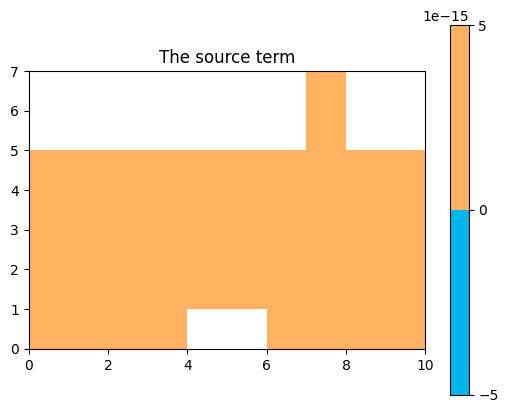

In [6]:
##############
# Source term
# fp_exp = Expression(('1e+2*exp(-pow((x[0]-0.5),2)/0.02 - pow((x[1]-0.5),2)/0.02)'), element = V.ufl_element())
fp_exp = Expression(('0.'), element = V.ufl_element())
fp = interpolate(fp_exp,V)
# Plot
p = plot(fp,title='The source term')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show()

In [8]:
# Define boundaries (useful for Dirichlet BC in particular)
def u_bdry_x0(x, on_boundary): # Left bdry
    return bool(on_boundary and (near(x[0], 0, tol_bc)))
def u_bdry_x1(x, on_boundary): # Right bdry
    return bool(on_boundary and (near(x[0], 10, tol_bc)))
def u_bdry_x0(x, on_boundary): # Roof bdry
    return bool(on_boundary and (near(x[1], 0, tol_bc)))


In [9]:
#######
# BCs

# Dirichlet BCs: non homogenous and homogeneous ones
u_diri_val = 3.e2
u_diri_non_hom_exp = Expression('3.e2', element = V.ufl_element()) 
u_diri_non_hom = interpolate(u_diri_non_hom_exp,V)
bc_non_hom = DirichletBC(V, u_diri_non_hom_exp, u_bdry_x0)
#print("The imposed Dirichlet value =", u_diri_non_hom)

u_diri0_exp = Expression('3.',element = V.ufl_element())
bc0 = DirichletBC(V, u_diri0_exp, u_bdry_x0)
bc1 = DirichletBC(V, u_diri0_exp, u_bdry_x1)
bcs = [bc0, bc1]

# Fluxes BC coefficients
#    Recall: flux BCs are imposed in the weak form
#c = 1. # coeff. value of the flux condition (Robin like condition)
c = 5.65e-8 # Stefan's constant value
q = 4 # the power-law index of the flux law 
u_ref_val = 3.3e2
u_ref_exp = Expression('3.3e2', element = V.ufl_element()) 
u_ref = interpolate(u_ref_exp,V)
print("The non-linear flux coefficients are: (c, q, u_ref) = ", (c,q,u_ref_val))

The non-linear flux coefficients are: (c, q, u_ref) =  (5.65e-08, 4, 330.0)


## 2) Coding the model using the implicit Euler scheme

### a) Semi-linearized model

In [95]:
# Set tolerance
tolerance = 1e-6

# Define initial condition u(x, 0) = 3
u_n = Function(V)
u_n.assign(Constant(3.0))

# Define constants
dt = 0.005
T = 0.1
num_steps = int(T / dt)


### The variational formula

$$ \int_Ω \partial_t uv + \int_Ω \mu \nabla u \nabla v + \int_{\Gamma_{Flux}} c(x) u v + \int_{\Gamma_{fire}} \sigma u^4 v = \int_Ω fv + \int_{\Gamma_{fire}} \sigma  u_f^4 v$$
Recall the $\theta$-scheme:
$$ M\frac{U_{n+1} - U_n}{\Delta t} + A(\theta U_{n+1} + (1-\theta)U_n) = \theta F_{n+1} + (1-\theta)F_n $$
For simplicity and stability, let's consider the Backward Euler method ($\theta=1$), which is an implicit method. This method approximates the time derivative as follows:
$$ \partial_t ≈ \frac{u_{n+1} - u_n}{\Delta t} $$

This results in the variational formulation:
$$ \int_Ω \frac{u_{n+1}}{\Delta t}v + \int_Ω \mu \nabla u_{n+1} \nabla v + \int_{\Gamma_{Flux}} c(x) u_{n+1} v + \int_{\Gamma_{fire}} \sigma u_{n+1}^4 v =\int_Ω \frac{u_n}{\Delta t}v + \int_Ω fv + \int_{\Gamma_{fire}} \sigma  u_f^4 v$$


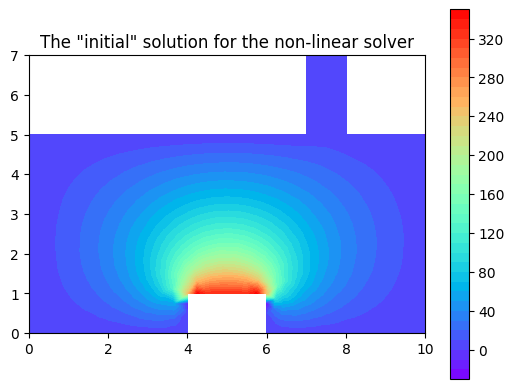

In [96]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

u = TrialFunction(V); v = TestFunction(V)
F0 = (
    mu0 * inner(grad(u),grad(v)) * dx  + 
    c * (u_ref**(q-1) * u - u_ref**q) * v * ds(6) + 
    wall_thick*u*v*ds(1) +
    roof_thick*u*v*ds(2) +
    chimney_thick*u*v*ds(3) +
    floor_thick*u*v*ds(4) +
    window_thick*u*v*ds(5) +
    wall_thick*u*v*ds(7)
)

F0 +=  - fp * v * dx 
a0 = lhs(F0); L0 = rhs(F0)
u_0 = Function(V)
solve(a0 == L0, u_0)

# Plot
plt.figure()
p = plot(u_0, title='The "initial" solution for the non-linear solver')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show(block=False)

## b) Implement the non-linear model


 Non-linear solver by Newton-Raphson algorithm... 
Newton-Raphson iteration 5 : CV criteria  = 0.0000000517792
The Euler implcite scheme # 0.005 ; error =  1.0
Newton-Raphson loop has finished at iteration  6  with CV criteria  =  7.36224466328634e-10
The Euler implcite scheme # 0.01 ; error =  0.0
Newton-Raphson loop has finished at iteration  6  with CV criteria  =  7.36224466328634e-10
A plot is on ...


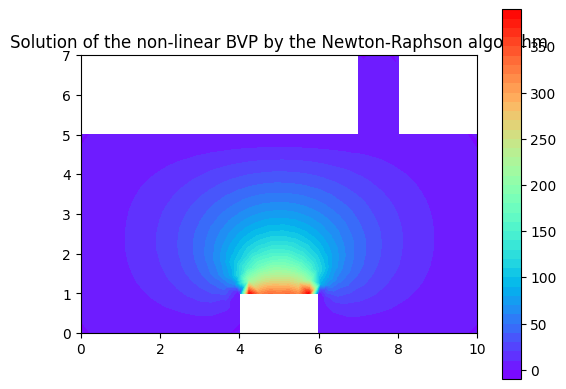

In [103]:
###########################
# Newton-Raphson algorithm 
# Case mu constant diffusivity. Non-linear term : non-linear flux
###########################
print("\n Non-linear solver by Newton-Raphson algorithm... ")
du = TrialFunction(V); dv = TestFunction(V) 
u_n = Function(V); u_n.assign(u_0)
u_k = Function(V); u_n.assign(u_0)
diff = Function(V)

i = 0; error = 1; t = 0
eps_t = 1e-4
for n in range(num_steps):
    t += dt
    while i < I_max and error > eps_du :
        i += 1
        # LHS
        da = (
        dt * mu0 * inner(grad(du), grad(v))*dx + 
        dt * q * c * u_n**(q-1) * du * v * ds(6) + 
        wall_thick*du*v*ds(1) +
        roof_thick*du*v*ds(2) +
        chimney_thick*du*v*ds(3) +
        floor_thick*du*v*ds(4) +
        window_thick*du*v*ds(5) +
        wall_thick*du*v*ds(7)
        )
        # RHS
        F = dt * fp*v*dx
        a_n = (
        # dt * mu0 * inner(grad(u_n),grad(v))*dx + 
        # dt * c * (u_n**q - u_ref**q) * v * ds(6) + #backward 
        wall_thick*u_n*v*ds(1) +
        roof_thick*u_n*v*ds(2) +
        chimney_thick*u_n*v*ds(3) +
        floor_thick*u_n*v*ds(4) +
        window_thick*u_n*v*ds(5) +
        wall_thick*u_n*v*ds(7)
        )
        L = F - a_n  
        
        du_n = Function(V)
        solve(da == L, du_n) # NB: homogeneous BC
    
        u_n.assign(u_n + du_n)
        # CV criteria  
        u_n_np = u_n.vector().get_local(); du_np = du_n.vector().get_local()
        error = npl.norm(du_np) / npl.norm(u_n_np)
        
        if i % 5 ==0 :
            print("Newton-Raphson iteration %i : CV criteria  = %.13f" %(i,error))
    diff.assign(u_k-u_n)
    u_k.assign(u_n)
    u_k_np=u_k.vector().get_local()
    diff_np= diff.vector().get_local()
    error_t= np.linalg.norm(diff_np) / np.linalg.norm(u_n_np)
    print("The Euler implcite scheme #",t,"; error = ", error_t)
    print("Newton-Raphson loop has finished at iteration ",i," with CV criteria  = ", error)
    if error_t < eps_t:
        break


# Plot
plt.figure()
p = plot(u_n, title='Solution of the non-linear BVP by the Newton-Raphson algorithm')
p.set_cmap("rainbow"); plt.colorbar(p)
print("A plot is on ..."); plt.show(block=False)

### Increasing the model complexity

In [63]:
w = Constant((0.05, 0.0))  # example wind field

Calling FFC just-in-time (JIT) compiler, this may take some time.


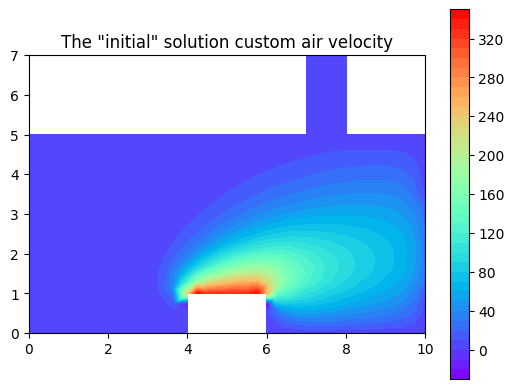

In [105]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

u = TrialFunction(V); v = TestFunction(V)
F0 = (
    mu0 * inner(grad(u),grad(v)) * dx  + 
    c * (u_ref**(q-1) * u - u_ref**q) * v * ds(6) + 
    inner(w, grad(u)) * v * dx + # Introduce convective transfers
    wall_thick*u*v*ds(1) +
    roof_thick*u*v*ds(2) +
    chimney_thick*u*v*ds(3) +
    floor_thick*u*v*ds(4) +
    window_thick*u*v*ds(5) +
    wall_thick*u*v*ds(7)
)

F0 +=  - fp * v * dx 
a0 = lhs(F0); L0 = rhs(F0)
u_0 = Function(V)
solve(a0 == L0, u_0)

# Plot
plt.figure()
p = plot(u_0, title='The "initial" solution custom air velocity')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show(block=False)


 Non-linear solver by Newton-Raphson algorithm... 
Newton-Raphson iteration 5 : CV criteria  = 0.0000000522675
The Euler implcite scheme # 0.005 ; error =  1.0
Newton-Raphson loop has finished at iteration  6  with CV criteria  =  7.400737586868288e-10
The Euler implcite scheme # 0.01 ; error =  0.0
Newton-Raphson loop has finished at iteration  6  with CV criteria  =  7.400737586868288e-10
A plot is on ...


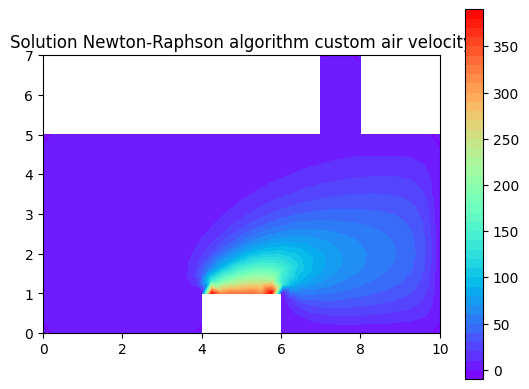

In [111]:
###########################
# Newton-Raphson algorithm 
# Case mu constant diffusivity. Non-linear term : non-linear flux
###########################
print("\n Non-linear solver by Newton-Raphson algorithm... ")
du = TrialFunction(V); dv = TestFunction(V) 
u_n = Function(V); u_n.assign(u_0)
u_k = Function(V); u_n.assign(u_0)
diff = Function(V)

i = 0; error = 1; t = 0
eps_t = 1e-4
for n in range(num_steps):
    t += dt
    while i < I_max and error > eps_du :
        i += 1
        # LHS
        da = (
        dt * mu0 * inner(grad(du), grad(v))*dx + 
        dt * q * c * u_n**(q-1) * du * v * ds(6) +
        dt * inner(w, grad(du)) * v * dx + # Introduce convective transfers
        wall_thick*du*v*ds(1) +
        roof_thick*du*v*ds(2) +
        chimney_thick*du*v*ds(3) +
        floor_thick*du*v*ds(4) +
        window_thick*du*v*ds(5) +
        wall_thick*du*v*ds(7)
        )
        # RHS
        F = dt * fp*v*dx
        a_n = (
        # dt * mu0 * inner(grad(u_n),grad(v))*dx + 
        # dt * c * (u_n**q - u_ref**q) * v * ds(6) +
        # dt * inner(w, grad(u_n)) * v * dx + # Introduce convective transfers
        wall_thick*u_n*v*ds(1) +
        roof_thick*u_n*v*ds(2) +
        chimney_thick*u_n*v*ds(3) +
        floor_thick*u_n*v*ds(4) +
        window_thick*u_n*v*ds(5) +
        wall_thick*u_n*v*ds(7)
        )
        L = F - a_n  
        
        du_n = Function(V)
        solve(da == L, du_n) # NB: homogeneous BC
    
        u_n.assign(u_n + du_n)
        # CV criteria  
        u_n_np = u_n.vector().get_local(); du_np = du_n.vector().get_local()
        error = npl.norm(du_np) / npl.norm(u_n_np)
        
        if i % 5 ==0 :
            print("Newton-Raphson iteration %i : CV criteria  = %.13f" %(i,error))
    diff.assign(u_k-u_n)
    u_k.assign(u_n)
    u_k_np=u_k.vector().get_local()
    diff_np= diff.vector().get_local()
    error_t= np.linalg.norm(diff_np) / np.linalg.norm(u_n_np)
    print("The Euler implcite scheme #",t,"; error = ", error_t)
    print("Newton-Raphson loop has finished at iteration ",i," with CV criteria  = ", error)
    if error_t < eps_t:
        break

# Plot
plt.figure()
p = plot(u_n, title='Solution Newton-Raphson algorithm custom air velocity')
p.set_cmap("rainbow"); plt.colorbar(p)
print("A plot is on ..."); plt.show(block=False)

### The variational formula for Crank-Nicholson scheme


$$ \int_Ω \partial_t uv + \int_Ω \mu \nabla u \nabla v + \int_{\Gamma_{Flux}} c(x) u v + \int_{\Gamma_{fire}} \sigma u^4 v = \int_Ω fv + \int_{\Gamma_{fire}} \sigma  u_f^4 v$$
Again, we consider the $\theta$-scheme:
$$ M\frac{U_{n+1} - U_n}{\Delta t} + A(\theta U_{n+1} + (1-\theta)U_n) = \theta F_{n+1} + (1-\theta)F_n $$
We simulate the Crank-Nicholson method ($\theta=0.5$), which is an implicit order 2 method.This results in the variational formulation:
$$ \int_Ω \frac{u_{n+1}}{\Delta t}v + \int_Ω 0.5 \mu \nabla u_{n+1} \nabla v + \int_{\Gamma_{Flux}} 0.5 c(x) u_{n+1} v + \int_{\Gamma_{fire}} 0.5 \sigma u_{n+1}^4 v $$
$$=\int_Ω \frac{u_n}{\Delta t}v - \int_Ω 0.5 \mu \nabla u_{n} \nabla v - \int_{\Gamma_{Flux}} 0.5 c(x) u_{n} v - \int_{\Gamma_{fire}} 0.5 \sigma u_{n}^4 v + \int_Ω fv + \int_{\Gamma_{fire}} \sigma  u_f^4 v$$


 Non-linear solver by Newton-Raphson algorithm... 
Newton-Raphson iteration 5 : CV criteria  = 0.0000000000114
The Euler implcite scheme # 0.005 ; error =  1.0
Newton-Raphson loop has finished at iteration  5  with CV criteria  =  1.1417821537312732e-11
The Euler implcite scheme # 0.01 ; error =  0.0
Newton-Raphson loop has finished at iteration  5  with CV criteria  =  1.1417821537312732e-11
A plot is on ...


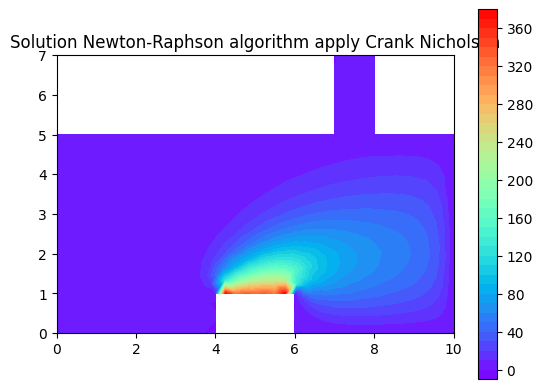

In [113]:
###########################
# Newton-Raphson algorithm 
# Case mu constant diffusivity. Non-linear term : non-linear flux
###########################
print("\n Non-linear solver by Newton-Raphson algorithm... ")
du = TrialFunction(V); dv = TestFunction(V) 
u_n = Function(V); u_n.assign(u_0)
u_k = Function(V); u_n.assign(u_0)
diff = Function(V)

i = 0; error = 1; t = 0
eps_t = 1e-4
for n in range(num_steps):
    t += dt
    while i < I_max and error > eps_du :
        i += 1
        # LHS
        da = (
        0.5*dt * mu0 * inner(grad(du), grad(v))*dx + 
        0.5*dt * q * c * u_n**(q-1) * du * v * ds(6) +
        0.5*dt * inner(w, grad(du)) * v * dx + # Introduce convective transfers
        wall_thick*du*v*ds(1) +
        roof_thick*du*v*ds(2) +
        chimney_thick*du*v*ds(3) +
        floor_thick*du*v*ds(4) +
        window_thick*du*v*ds(5) +
        wall_thick*du*v*ds(7)
        )
        # RHS
        F = dt * fp*v*dx
        a_n = (
        0.5*dt * mu0 * inner(grad(u_n),grad(v))*dx + 
        0.5*dt * c * (u_n**q - u_ref**q) * v * ds(6) +
        0.5*dt * inner(w, grad(u_n)) * v * dx + # Introduce convective transfers
        wall_thick*u_n*v*ds(1) +
        roof_thick*u_n*v*ds(2) +
        chimney_thick*u_n*v*ds(3) +
        floor_thick*u_n*v*ds(4) +
        window_thick*u_n*v*ds(5) +
        wall_thick*u_n*v*ds(7)
        )
        L = F - a_n  
        
        du_n = Function(V)
        solve(da == L, du_n) # NB: homogeneous BC
    
        u_n.assign(u_n + du_n)
        # CV criteria  
        u_n_np = u_n.vector().get_local(); du_np = du_n.vector().get_local()
        error = npl.norm(du_np) / npl.norm(u_n_np)
        
        if i % 5 ==0 :
            print("Newton-Raphson iteration %i : CV criteria  = %.13f" %(i,error))
    diff.assign(u_k-u_n)
    u_k.assign(u_n)
    u_k_np=u_k.vector().get_local()
    diff_np= diff.vector().get_local()
    error_t= np.linalg.norm(diff_np) / np.linalg.norm(u_n_np)
    print("The Euler implcite scheme #",t,"; error = ", error_t)
    print("Newton-Raphson loop has finished at iteration ",i," with CV criteria  = ", error)
    if error_t < eps_t:
        break
    


# Plot
plt.figure()
p = plot(u_n, title='Solution Newton-Raphson algorithm apply Crank Nicholson')
p.set_cmap("rainbow"); plt.colorbar(p)
print("A plot is on ..."); plt.show(block=False)$

## Simple model to define the fluid velocity w
You here compute the fluid velocity w by solving a basic fluid flow model, namely the potential flow model. The fluid velocity is assumed to derive from apotentialV :$w=∇V$.
Assuming a steady-state flow and using the incompressibility assumption $div(w) = 0$, it follows the equations :
$−\Delta V(x,t) = 0 \ in\  Ω$, for t (3)

with the BCs

$\nabla V (x, t) \cdot n(x) = 0$ on $\Gamma_{wall}$ (4) 

$V =V_{in}$ on $\Gamma_{in}$ ; 

$V =V_{out}  =0 \ on \ \Gamma_{out}$ (5)

We need to define the inlet and the outlet, let them be the window and the chimney respectively. We need to redefine the chimney outlet since it is different from the whole chimney.


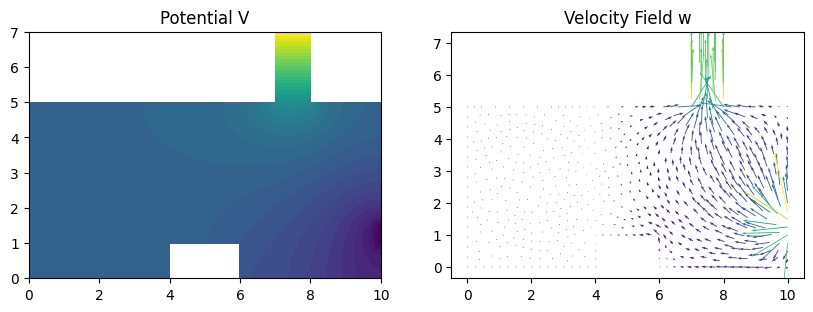

In [118]:
# Define boundary conditions for potential flow
V_in_value = Constant(-1.0)  # Example inlet potential
V_out_value = Constant(0.0)  # Example outlet potential

# Define boundaries
class InletWindow(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 10) and between(x[1], (1, 1.5)))

class OutletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 7)

inlet = InletWindow()
outlet = OutletBoundary()

boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
inlet.mark(boundary_markers, 1)
outlet.mark(boundary_markers, 2)

do = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

# Define boundary conditions
bc_inlet = DirichletBC(V, V_in_value, inlet)
bc_outlet = DirichletBC(V, V_out_value, outlet)

bcs = [bc_inlet, bc_outlet]

# Define variational problem for potential flow
V_potential = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(V_potential), grad(v)) * dx
L = Constant(0) * v * dx 

# Solve the potential flow problem
V_solution = Function(V)
solve(a == L, V_solution, bcs)

# Compute the fluid velocity w = grad(V)
w2 = project(grad(V_solution), VectorFunctionSpace(mesh, 'P', 1))

# Plot the solution
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot(V_solution, title="Potential V")
plt.subplot(1,2,2)
plot(w2, title="Velocity Field w")
plt.show()


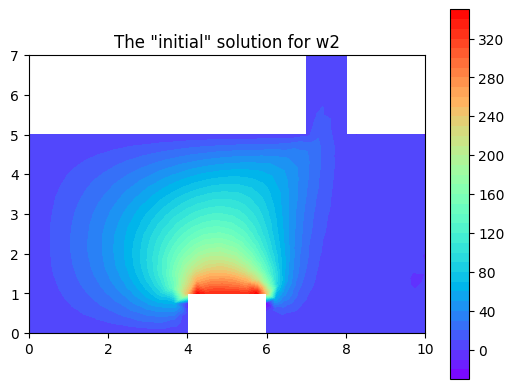

In [129]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

u = TrialFunction(V); v = TestFunction(V)
F0 = (
    mu0 * inner(grad(u),grad(v)) * dx  + 
    c * (u_ref**(q-1) * u - u_ref**q) * v * ds(6) + 
    inner(w2, grad(u)) * v * dx + # Introduce convective transfers
    wall_thick*u*v*ds(1) +
    roof_thick*u*v*ds(2) +
    chimney_thick*u*v*ds(3) +
    floor_thick*u*v*ds(4) +
    window_thick*u*v*ds(5) +
    wall_thick*u*v*ds(7)
)

F0 +=  - fp * v * dx 
a0 = lhs(F0); L0 = rhs(F0)
u_0 = Function(V)
solve(a0 == L0, u_0)

# Plot
plt.figure()
p = plot(u_0, title='The "initial" solution for w2')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show(block=False)


 Non-linear solver by Newton-Raphson algorithm... 
Newton-Raphson iteration 5 : CV criteria  = 0.0000000507534
The Euler implcite scheme # 0.005 ; error =  1.0
Newton-Raphson loop has finished at iteration  6  with CV criteria  =  7.282925928788216e-10
The Euler implcite scheme # 0.01 ; error =  0.0
Newton-Raphson loop has finished at iteration  6  with CV criteria  =  7.282925928788216e-10
A plot is on ...


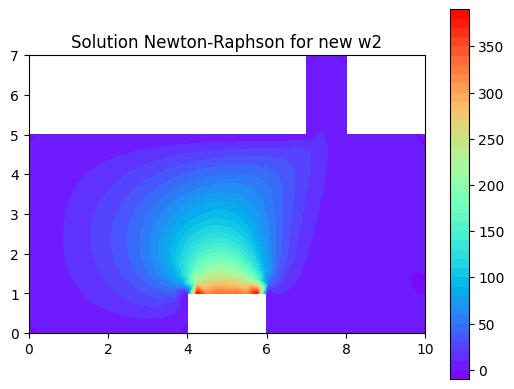

In [131]:
###########################
# Newton-Raphson algorithm 
# Case mu constant diffusivity. Non-linear term : non-linear flux
###########################
print("\n Non-linear solver by Newton-Raphson algorithm... ")
du = TrialFunction(V); dv = TestFunction(V) 
u_n = Function(V); u_n.assign(u_0)
u_k = Function(V); u_n.assign(u_0)
diff = Function(V)

i = 0; error = 1; t = 0
eps_t = 1e-4
for n in range(num_steps):
    t += dt
    while i < I_max and error > eps_du :
        i += 1
        # LHS
        da = (
        dt * mu0 * inner(grad(du), grad(v))*dx + 
        dt * q * c * u_n**(q-1) * du * v * ds(6) +
        dt * inner(w2, grad(du)) * v * dx + # Introduce convective transfers
        wall_thick*du*v*ds(1) +
        roof_thick*du*v*ds(2) +
        chimney_thick*du*v*ds(3) +
        floor_thick*du*v*ds(4) +
        window_thick*du*v*ds(5) +
        wall_thick*du*v*ds(7)
        )
        # RHS
        F = dt * fp*v*dx
        a_n = (
        # dt * mu0 * inner(grad(u_n),grad(v))*dx + 
        # dt * c * (u_n**q - u_ref**q) * v * ds(6) +
        # dt * inner(w2, grad(u_n)) * v * dx + # Introduce convective transfers
        wall_thick*u_n*v*ds(1) +
        roof_thick*u_n*v*ds(2) +
        chimney_thick*u_n*v*ds(3) +
        floor_thick*u_n*v*ds(4) +
        window_thick*u_n*v*ds(5) +
        wall_thick*u_n*v*ds(7)
        )
        L = F - a_n  
        
        du_n = Function(V)
        solve(da == L, du_n) # NB: homogeneous BC
    
        u_n.assign(u_n + du_n)
        # CV criteria  
        u_n_np = u_n.vector().get_local(); du_np = du_n.vector().get_local()
        error = npl.norm(du_np) / npl.norm(u_n_np)
        
        if i % 5 ==0 :
            print("Newton-Raphson iteration %i : CV criteria  = %.13f" %(i,error))
    diff.assign(u_k-u_n)
    u_k.assign(u_n)
    u_k_np=u_k.vector().get_local()
    diff_np= diff.vector().get_local()
    error_t= np.linalg.norm(diff_np) / np.linalg.norm(u_n_np)
    print("The Euler implcite scheme #",t,"; error = ", error_t)
    print("Newton-Raphson loop has finished at iteration ",i," with CV criteria  = ", error)
    if error_t < eps_t:
        break

# u_h for computing error
u_h =Function(V)
u_h.assign(u_n)
# Plot
plt.figure()
p = plot(u_n, title='Solution Newton-Raphson for new w2')
p.set_cmap("rainbow"); plt.colorbar(p)
print("A plot is on ..."); plt.show(block=False)

## Actual order of computation code

### Heat Equation Source Term

Given the heat equation in the form:
$$ \frac{\partial u}{\partial t} - \Delta u = f $$

Substituting the exact solution $ u_e(x_1, x_2) $:
$$ u_e(x_1, x_2) = \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$

The Laplacian of \( u_e \) is:
$$ \Delta u_e = \frac{\partial^2 u_e}{\partial x_1^2} + \frac{\partial^2 u_e}{\partial x_2^2} $$

Calculating the second derivatives:
$$ \frac{\partial^2 u_e}{\partial x_1^2} = -\omega_1^2 \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$
$$ \frac{\partial^2 u_e}{\partial x_2^2} = -\omega_2^2 \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$

Thus:
$$ \Delta u_e = -\omega_1^2 \cos(\omega_1 x_1) \sin(\omega_2 x_2) - \omega_2^2 \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$
$$ \Delta u_e = -(\omega_1^2 + \omega_2^2) \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$

So, the source term $ f $ in the heat equation is:
$$ f = \frac{\partial u_e}{\partial t} - \Delta u_e $$
Since the solution $ u_e $ is steady-state (i.e., $\frac{\partial u_e}{\partial t} = 0$):
$$ f = -\Delta u_e = (\omega_1^2 + \omega_2^2) \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$


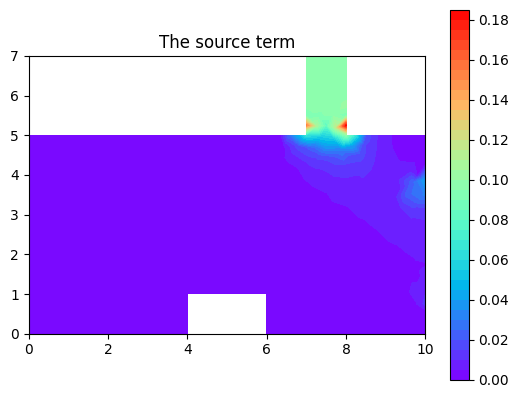

In [38]:
# Extract components w_0 and w_1
w_0 = w2.sub(0, deepcopy=True)
w_1 = w2.sub(1, deepcopy=True)

# Source term expression
fp_exp2 = Expression('pow(w0, 2) + pow(w1, 2)', w0=w_0, w1=w_1, element = V.ufl_element())

##############
# Source term
# fp_exp = Expression(('(w_0**2+w_1**2)cos(w_0*x[0])sin(w_1*x[1]'), element = V.ufl_element())
# fp_exp = Expression(('0.'), element = V.ufl_element())
fp2 = interpolate(fp_exp2,V)
# Plot
p = plot(fp2,title='The source term')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show()

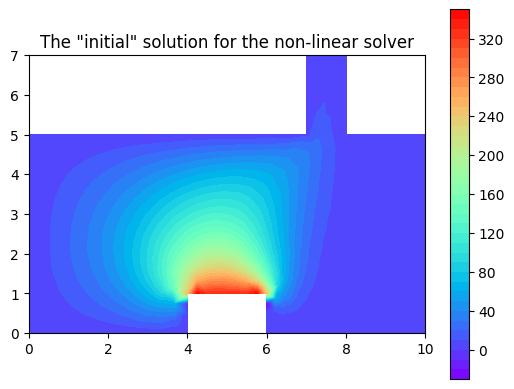

In [132]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

u = TrialFunction(V); v = TestFunction(V)
F0 = (
    mu0 * inner(grad(u),grad(v)) * dx  + 
    c * (u_ref**(q-1) * u - u_ref**q) * v * ds(6) + 
    inner(w2, grad(u)) * v * dx + # Introduce convective transfers
    wall_thick*u*v*ds(1) +
    roof_thick*u*v*ds(2) +
    chimney_thick*u*v*ds(3) +
    floor_thick*u*v*ds(4) +
    window_thick*u*v*ds(5) +
    wall_thick*u*v*ds(7)
)

F0 +=  - fp2 * v * dx # Introduce new source term
a0 = lhs(F0); L0 = rhs(F0)
u_0 = Function(V)
solve(a0 == L0, u_0)

# Plot
plt.figure()
p = plot(u_0, title='The "initial" solution for the non-linear solver')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show(block=False)


 Non-linear solver by Newton-Raphson algorithm... 
Newton-Raphson iteration 5 : CV criteria  = 0.0000000000060
The Euler implcite scheme # 0.005 ; error =  1.0
Newton-Raphson loop has finished at iteration  5  with CV criteria  =  5.997871118266666e-12
The Euler implcite scheme # 0.01 ; error =  0.0
Newton-Raphson loop has finished at iteration  5  with CV criteria  =  5.997871118266666e-12
A plot is on ...


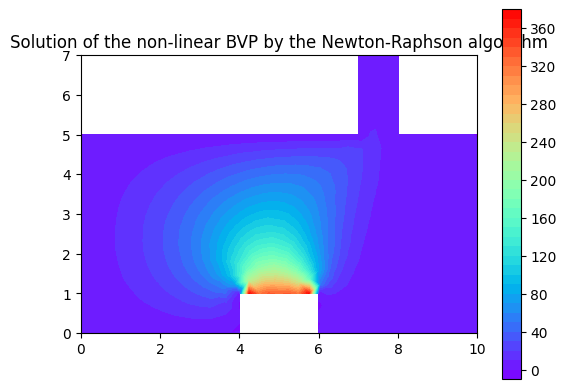

In [133]:
###########################
# Newton-Raphson algorithm 
# Case mu constant diffusivity. Non-linear term : non-linear flux
###########################
print("\n Non-linear solver by Newton-Raphson algorithm... ")
du = TrialFunction(V); dv = TestFunction(V) 
u_n = Function(V); u_n.assign(u_0)
u_k = Function(V); u_n.assign(u_0)
diff = Function(V)

i = 0; error = 1; t = 0
eps_t = 1e-4
for n in range(num_steps):
    t += dt
    while i < I_max and error > eps_du :
        i += 1
        # LHS
        da = (
        0.5*dt * mu0 * inner(grad(du), grad(v))*dx + 
        0.5*dt * q * c * u_n**(q-1) * du * v * ds(6) +
        0.5*dt * inner(w2, grad(du)) * v * dx + # Introduce convective transfers
        wall_thick*du*v*ds(1) +
        roof_thick*du*v*ds(2) +
        chimney_thick*du*v*ds(3) +
        floor_thick*du*v*ds(4) +
        window_thick*du*v*ds(5) +
        wall_thick*du*v*ds(7)
        )
        # RHS
        F = dt * fp2*v*dx # New source term
        a_n = (
        0.5*dt * mu0 * inner(grad(u_n),grad(v))*dx + 
        0.5*dt * c * (u_n**q - u_ref**q) * v * ds(6) +
        0.5*dt * inner(w2, grad(u_n)) * v * dx + # Introduce convective transfers
        wall_thick*u_n*v*ds(1) +
        roof_thick*u_n*v*ds(2) +
        chimney_thick*u_n*v*ds(3) +
        floor_thick*u_n*v*ds(4) +
        window_thick*u_n*v*ds(5) +
        wall_thick*u_n*v*ds(7)
        )
        L = F - a_n  
        
        du_n = Function(V)
        solve(da == L, du_n) # NB: homogeneous BC
    
        u_n.assign(u_n + du_n)
        # CV criteria  
        u_n_np = u_n.vector().get_local(); du_np = du_n.vector().get_local()
        error = npl.norm(du_np) / npl.norm(u_n_np)
        
        if i % 5 ==0 :
            print("Newton-Raphson iteration %i : CV criteria  = %.13f" %(i,error))
    diff.assign(u_k-u_n)
    u_k.assign(u_n)
    u_k_np=u_k.vector().get_local()
    diff_np= diff.vector().get_local()
    error_t= np.linalg.norm(diff_np) / np.linalg.norm(u_n_np)
    print("The Euler implcite scheme #",t,"; error = ", error_t)
    print("Newton-Raphson loop has finished at iteration ",i," with CV criteria  = ", error)
    if error_t < eps_t:
        break

# u_ex to compute error
u_ex = Function(V)
u_ex.assign(u_n)
# Plot
plt.figure()
p = plot(u_n, title='Solution of the non-linear BVP by the Newton-Raphson algorithm')
p.set_cmap("rainbow"); plt.colorbar(p)
print("A plot is on ..."); plt.show(block=False)

In [135]:
u_h_np=u_h.vector().get_local()
u_ex_np= u_ex.vector().get_local()
error_tot= np.linalg.norm(u_ex_np-u_h_np) / np.linalg.norm(u_ex_np)
print("The error ||uex − uh||/||uex|| is", error_tot)

The error ||uex − uh||/||uex|| is 0.012982220641837355
